In [ ]:
!pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 116.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48

In [ ]:
from collections import OrderedDict
from typing import List, Tuple
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
# disable_progress_bar controls the visibility of progress bars
from torch.utils.data import DataLoader
import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset

NUM_CLIENTS = 10
BATCH_SIZE = 32

from flwr_datasets.partitioner import PathologicalPartitioner

partitioner = PathologicalPartitioner(
    num_partitions=NUM_CLIENTS,
    partition_by="label",
    num_classes_per_partition=2,
    class_assignment_mode="random", # ['random', 'deterministic', 'first-deterministic']
    seed=42
)

def load_datasets(partition_id: int):
    fds=FederatedDataset(dataset="cifar10", partitioners={"train": partitioner})
    partition=fds.load_partition(partition_id)

    print(f"Partition {partition_id} size: {len(partition)}")
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
    print(f"Partition {partition_id} train size: {len(partition_train_test['train'])}")
    print(f"Partition {partition_id} test size: {len(partition_train_test['test'])}")

    pytorch_transforms = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]
    )
    def apply_transforms(batch):
        batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
        return batch

    partition_train_test = partition_train_test.with_transform(apply_transforms)
    train_batch_size = min(BATCH_SIZE, max(2, len(partition_train_test["train"])))

    trainloader = DataLoader(
        partition_train_test["train"],
        batch_size=train_batch_size,
        shuffle=True,
        drop_last=(len(partition_train_test["train"]) % train_batch_size == 1)
    )

    valloader = DataLoader(
        partition_train_test["test"],
        batch_size=BATCH_SIZE,
        drop_last=(len(partition_train_test["test"]) == 1)
    )

    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)

    return trainloader, valloader, testloader

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

class Net(nn.Module):
    def __init__(self, num_classes=10):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict()
    for k, v in params_dict:
        if v.size == 0:
            print(f"Warning: Parameter {k} is empty!")
            continue
        state_dict[k] = torch.tensor(v)

    net.load_state_dict(state_dict, strict=True)

In [ ]:
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())

    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images,labels=batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            if images.size(0)<=1:
                continue
            else:
                optimizer.zero_grad()
                outputs = net(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
                total += labels.size(0)
                correct += (torch.max(outputs.data,1)[1]==labels).sum().item()

        if total>0:
            epoch_loss /= total
            epoch_acc = correct / total
            if verbose:
                print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")

In [ ]:
def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [ ]:
class FlowerClient(NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [ ]:
def client_fn(context: Context) -> Client:
    """Create a Flower client representing a single organization."""
    net = Net().to(DEVICE)
    print(f"Context data: {context.__dict__}")

    partition_id = int(context.node_id) % NUM_CLIENTS if hasattr(context, 'node_id') else 0
    if hasattr(context, 'node_config') and 'partition_id' in context.node_config:
        partition_id = context.node_config['partition_id']

    print(f"Using partition_id: {partition_id}")
    trainloader, valloader, _ = load_datasets(partition_id=partition_id)
    return FlowerClient(net, trainloader, valloader).to_client()

client = ClientApp(client_fn=client_fn)

In [ ]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    return {"accuracy": sum(accuracies) / sum(examples)}

In [ ]:
test_accuracies = []

class CustomFedAvg(FedAvg):
    def aggregate_evaluate(self, server_round, results, failures):
        aggregated_result=super().aggregate_evaluate(server_round,results,failures)

        if aggregated_result is not None:
            loss,metrics=aggregated_result
            accuracy=metrics.get("accuracy",0.0)
            test_accuracies.append(accuracy)
            print(f"Round {server_round}: Test Accuracy: {accuracy:.4f}")
        return aggregated_result

In [ ]:
strategy = CustomFedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average,
)

In [ ]:
def server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=50)
    return ServerAppComponents(strategy=strategy, config=config)

server = ServerApp(server_fn=server_fn)

In [ ]:
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}

In [ ]:
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

DEBUG:flwr:Asyncio event loop already running.
INFO :      Starting Flower ServerApp, config: num_rounds=50, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=1168) 2025-04-28 15:30:58.328978: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=1168) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=1168) E0000 00:00:1745854258.355822    1168 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=1168) E0000 00:00:1745854258.362093    1168 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/jupyter_client/co

(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


Generating test split: 100%|██████████| 10000/10000 [00:00<00:00, 111415.81 examples/s]
(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 1: Test Accuracy: 0.2665
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 2: Test Accuracy: 0.4221
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 3: Test Accuracy: 0.4843
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 4: Test Accuracy: 0.6286
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 5: Test Accuracy: 0.0776
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 6: Test Accuracy: 0.3867
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 7: Test Accuracy: 0.6228
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 8: Test Accuracy: 0.5481
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 9: Test Accuracy: 0.5219
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 10: Test Accuracy: 0.5612
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 11: Test Accuracy: 0.3748
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 12: Test Accuracy: 0.5882
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 13: Test Accuracy: 0.5612
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 14: Test Accuracy: 0.7249
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
Round 15: Test Accuracy: 0.5931
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
Round 16: Test Accuracy: 0.4209
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 17: Test Accuracy: 0.4613
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 18: Test Accuracy: 0.6149
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 19: Test Accuracy: 0.7545
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 20: Test Accuracy: 0.6253
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 21: Test Accuracy: 0.6407
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) 
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 22: Test Accuracy: 0.5158
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 23: Test Accuracy: 0.5169
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 24: Test Accuracy: 0.7553
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 25: Test Accuracy: 0.6802
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 26: Test Accuracy: 0.6477
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 27: Test Accuracy: 0.6692
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 28: Test Accuracy: 0.7035
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 29: Test Accuracy: 0.6626
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 30: Test Accuracy: 0.7821
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 31: Test Accuracy: 0.6699
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 32: Test Accuracy: 0.5028
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 33: Test Accuracy: 0.7563
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 34: Test Accuracy: 0.6447
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 35: Test Accuracy: 0.5398
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 36: Test Accuracy: 0.6699
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 37: Test Accuracy: 0.6537
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 38: Test Accuracy: 0.7488
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 39: Test Accuracy: 0.7664
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 40: Test Accuracy: 0.6663
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 41: Test Accuracy: 0.4434
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 42: Test Accuracy: 0.6525
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 43: Test Accuracy: 0.6618
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 44: Test Accuracy: 0.6812
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 45: Test Accuracy: 0.6554
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 46: Test Accuracy: 0.5950
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1
(ClientAppActor pid=1168) 


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 47: Test Accuracy: 0.6525
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 48: Test Accuracy: 0.6751
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 49: Test Accuracy: 0.6689
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 6663904762481277541, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 11915506174359538837, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2727501562537554242, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 5275454986662146744, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2704534960388370662, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 12925382732844777134, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 4


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 4 size: 2501
(ClientAppActor pid=1168) Partition 4 train size: 2000
(ClientAppActor pid=1168) Partition 4 test size: 501
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 2249965087303924758, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 8


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 8 size: 2499
(ClientAppActor pid=1168) Partition 8 train size: 1999
(ClientAppActor pid=1168) Partition 8 test size: 500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 16855207736717003437, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 7


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 7 size: 7500
(ClientAppActor pid=1168) Partition 7 train size: 6000
(ClientAppActor pid=1168) Partition 7 test size: 1500
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 101057143570705571, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 1


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 1 size: 5000
(ClientAppActor pid=1168) Partition 1 train size: 4000
(ClientAppActor pid=1168) Partition 1 test size: 1000
(ClientAppActor pid=1168) Context data: {'run_id': 12388884634357529996, 'node_id': 10232508871820163302, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1168)   array_records={},
(ClientAppActor pid=1168)   metric_records={},
(ClientAppActor pid=1168)   config_records={}
(ClientAppActor pid=1168) ), 'run_config': {}}
(ClientAppActor pid=1168) Using partition_id: 2


(ClientAppActor pid=1168) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1168)   warnings.warn(


(ClientAppActor pid=1168) Partition 2 size: 3334
(ClientAppActor pid=1168) Partition 2 train size: 2667
(ClientAppActor pid=1168) Partition 2 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 50 round(s) in 4448.79s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.06552455892550078
INFO :      		round 2: 0.04952279898582626
INFO :      		round 3: 0.04585758460533443
INFO :      		round 4: 0.03620807874570485
INFO :      		round 5: 0.05628188990004842
INFO :      		round 6: 0.043833689425969366
INFO :      		round 7: 0.03436358800162363
INFO :      		round 8: 0.03904743080107053
INFO :      		round 9: 0.038683971938405545
INFO :      		round 10: 0.03799734311081376
INFO :      		round 11: 0.045361823959819185
INFO :      		round 12: 0.0357678136533424
INFO :      		round 13: 0.03388586426959099
INFO :      		round 14: 0.027732071758775127
INFO :      		round 15: 0.03311451058380437
INFO :      		round 16: 0.04176982369143279
INFO :      		round 17: 0.04187590143971852
INFO :      		round 18: 0.031608453347926065
INFO :      		round 1

Round 50: Test Accuracy: 0.6394


In [ ]:
print("\n===== SUMMARY OF TEST ACCURACIES =====")
for round_num, accuracy in enumerate(test_accuracies, 1):
    print(f"Round {round_num}: {accuracy:.4f}")
print("=====================================\n")


===== SUMMARY OF TEST ACCURACIES =====
Round 1: 0.2665
Round 2: 0.4221
Round 3: 0.4843
Round 4: 0.6286
Round 5: 0.0776
Round 6: 0.3867
Round 7: 0.6228
Round 8: 0.5481
Round 9: 0.5219
Round 10: 0.5612
Round 11: 0.3748
Round 12: 0.5882
Round 13: 0.5612
Round 14: 0.7249
Round 15: 0.5931
Round 16: 0.4209
Round 17: 0.4613
Round 18: 0.6149
Round 19: 0.7545
Round 20: 0.6253
Round 21: 0.6407
Round 22: 0.5158
Round 23: 0.5169
Round 24: 0.7553
Round 25: 0.6802
Round 26: 0.6477
Round 27: 0.6692
Round 28: 0.7035
Round 29: 0.6626
Round 30: 0.7821
Round 31: 0.6699
Round 32: 0.5028
Round 33: 0.7563
Round 34: 0.6447
Round 35: 0.5398
Round 36: 0.6699
Round 37: 0.6537
Round 38: 0.7488
Round 39: 0.7664
Round 40: 0.6663
Round 41: 0.4434
Round 42: 0.6525
Round 43: 0.6618
Round 44: 0.6812
Round 45: 0.6554
Round 46: 0.5950
Round 47: 0.6525
Round 48: 0.6751
Round 49: 0.6689
Round 50: 0.6394



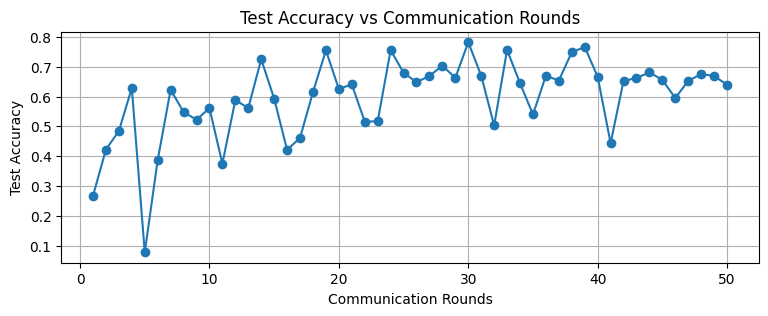

In [ ]:
def plot_accuracy_vs_rounds():
    if test_accuracies:
        plt.figure(figsize=(9,3))
        plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, marker='o', linestyle='-')
        plt.title('Test Accuracy vs Communication Rounds')
        plt.xlabel('Communication Rounds')
        plt.ylabel('Test Accuracy')
        plt.grid(True)
        plt.savefig('accuracy_vs_rounds.png')
        plt.show()
    else:
        print("No accuracy data collected to plot.")

plot_accuracy_vs_rounds()